In [75]:
import numpy as np
import pandas as pd
from functions.data_preperation import process_model_data
from functions.q_generator import two_qubit_circuit_tickers
from functions.model_test import plot_training_metrics, get_latest_model_path, calculate_rmse, plot_rmse_per_epoch, generate_data, compare_tickers_scatter
from qiskit.providers.fake_provider import GenericBackendV2
from sklearn.metrics import mean_squared_error

## Load the model

In [76]:
model_directory ="models/"
latest_model_path = get_latest_model_path(model_directory)
latest_model_path = "/Users/a01milner/Documents/Schro-horse/models/models_0310.0941"
print(latest_model_path)

/Users/a01milner/Documents/Schro-horse/models/models_0310.0941


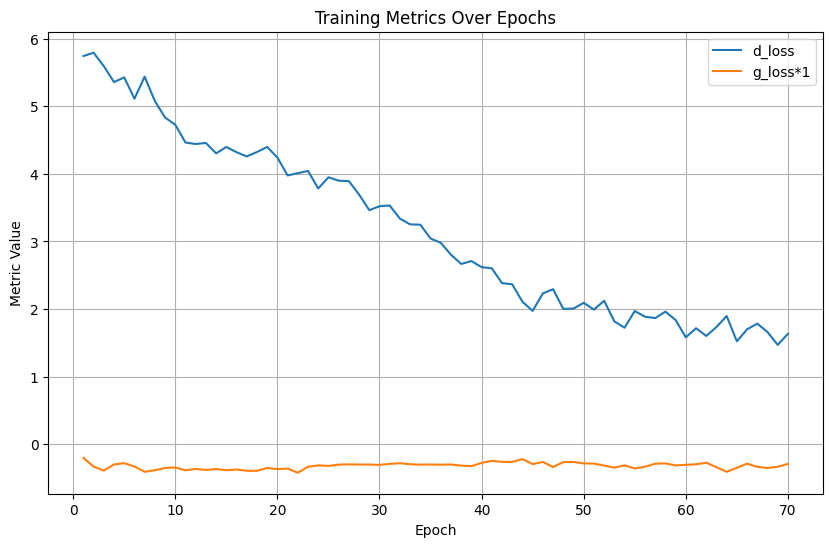

In [77]:
plot_training_metrics(f"{latest_model_path}/logs", generator_loss_scaling=1)

In [78]:
targets = ["OC_next", "CO_next"]
features = ["Close", "High", "Low", "Open", "Volume", "MACD", "Signal_Line", "EMA_20"]
tickers = ['GOOG','AAPL','MSFT','AMZN']

## Load data

In [79]:
# Load data
feature_data, target_data = process_model_data(targets, features, tickers)

/Users/a01milner/Documents/Schro-horse/functions/data_preperation.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['GOOG']: SSLError('Failed to perform, curl: (35) TLS connect error: error:00000000:invalid library (0):OPENSSL_internal:invalid library (0). See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
/Users/a01milner/Documents/Schro-horse/functions/data_preperation.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/Users/a01milner/Documents/Schro-horse/functions/data_preperation.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date,

(0,) (0,)


## Load the Qiskit circuit

[Parameter(AAAA), Parameter(AAAB), Parameter(AAAC), Parameter(AAAD), Parameter(AAAE), Parameter(AAAF), Parameter(AAAG), Parameter(AAAH), Parameter(AAAI), Parameter(AAAJ), Parameter(AAAK), Parameter(AAAL), Parameter(AAAM), Parameter(AAAN), Parameter(AAAO), Parameter(AAAP), Parameter(AAAQ), Parameter(AAAR), Parameter(AAAS), Parameter(AAAT), Parameter(AAAU), Parameter(AAAV), Parameter(AAAW), Parameter(AAAX), Parameter(AAAY), Parameter(AAAZ), Parameter(AABA), Parameter(AABB), Parameter(AABC), Parameter(AABD), Parameter(AABE), Parameter(AABF), Parameter(WAAA), Parameter(WAAB), Parameter(WAAC), Parameter(WAAD), Parameter(WAAE), Parameter(WAAF), Parameter(WAAG), Parameter(WAAH), Parameter(WAAI), Parameter(WAAJ), Parameter(WAAK), Parameter(WAAL), Parameter(WAAM), Parameter(WAAN), Parameter(WAAO), Parameter(WAAP), Parameter(WAAQ), Parameter(WAAR), Parameter(WAAS), Parameter(WAAT), Parameter(WAAU), Parameter(WAAV), Parameter(WAAW), Parameter(WAAX), Parameter(WAAY), Parameter(WAAZ), Parameter(WAB

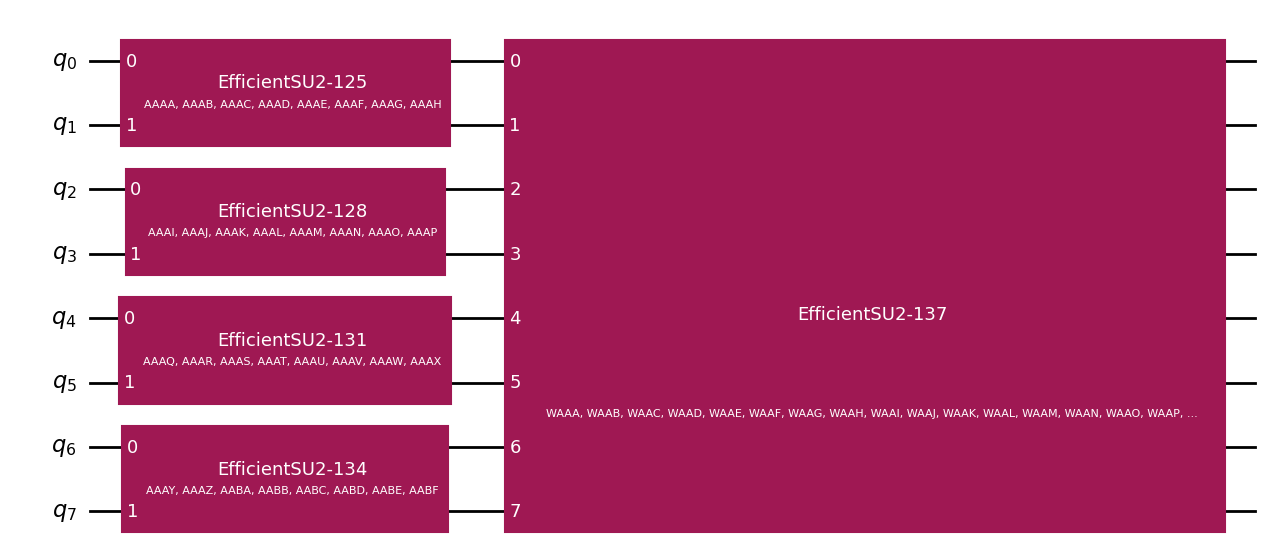

In [80]:
# Load circuit
qc= two_qubit_circuit_tickers(tickers)
print(list(qc.parameters))
qc.draw('mpl')

In [81]:
# Load weights
loaded_weights = np.load(f"{latest_model_path}/logs/generator_weights_epoch50.npy")

In [82]:
# Generate Data
# data is randomly sampled so returns the generated data along with the associated real data (if samplig=True)

backend = GenericBackendV2(num_qubits=qc.num_qubits)

outputs, target_outputs = generate_data(
    generator_weights = loaded_weights,
    qc = qc,
    feature_data = feature_data,
    target_data = target_data,
    backend = backend,
    sampling = True,
    sample_size = 100,
)

ValueError: a must be greater than 0 unless no samples are taken

## Finding the Root Mean Squared Errors
This is a better accuracy metric for us as the generator/discriminator loss doesn't tell us much

An RMSE of 0.10 means we are off by 10%

In [ ]:
# Calculate RMSE for each ticker and output feature
rmse_dict = calculate_rmse(
    generated_data= outputs,
    target_data= target_outputs, 
    ticker_labels= tickers,
    target_labels = targets
)

for k, v in rmse_dict.items():
        print(f"{k}: {v:.4f}")

avg_rmse = mean_squared_error(target_outputs, outputs)
print(f"Average RMSE: {avg_rmse}")

GOOG_OC_next: 1.1786
GOOG_CO_next: 1.0624
AAPL_OC_next: 1.0948
AAPL_CO_next: 1.1443
MSFT_OC_next: 0.9525
MSFT_CO_next: 0.9071
AMZN_OC_next: 0.8663
AMZN_CO_next: 1.0618
Average RMSE: 1.0791876316070557


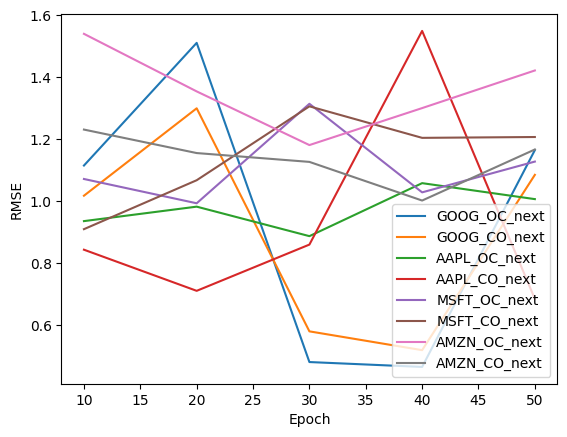

In [ ]:
# Plot the RMSE per epoch
rmse_per_epoch=plot_rmse_per_epoch(model_path=latest_model_path,
                    qc=qc, 
                    feature_data=feature_data, 
                    target_data=target_data, 
                    target_labels=targets, 
                    ticker_labels=tickers, 
                    sample_size = 100,
                    every_n_epochs=10,
)

## Comparing to random weights

In [ ]:
random_weights = np.random.randn(len(loaded_weights))

random_outputs, random_target_outputs = generate_data(
    generator_weights = loaded_weights,
    qc = qc,
    feature_data = feature_data,
    target_data = target_data,
    backend = backend,
    sampling = True,
    sample_size = 500,
)
random_rmse = mean_squared_error(random_target_outputs, random_outputs)
print(f"Average RMSE for random weights: {random_rmse}")
print(f"Average RMSE for trained weights: {avg_rmse}")

Average RMSE for random weights: 1.1614058017730713
Average RMSE for trained weights: 1.0791876316070557


## Plotting the ticker comparison distributions

In [ ]:
# Turning the results into a df
columns = [f"{ticker}_{target}" for ticker in tickers for target in targets]

df_gen = pd.DataFrame(outputs, columns=columns)
df_real = pd.DataFrame(target_outputs, columns=columns)


In [ ]:
df_gen.head()

,GOOG_OC_next,GOOG_CO_next,AAPL_OC_next,AAPL_CO_next,MSFT_OC_next,MSFT_CO_next,AMZN_OC_next,AMZN_CO_next
0,0.027426,0.594006,-0.016413,-1.242100,-0.306101,-0.203159,-0.119270,-1.089377
1,1.426477,-2.004245,0.600272,1.516422,-0.423246,0.844894,-0.208045,-0.472115
2,0.333118,0.242342,-0.740664,-0.431098,0.145359,-0.137102,-0.405934,1.105492
3,0.633679,0.714936,0.239174,-0.472075,0.003594,-0.131723,0.314943,2.059886
4,1.817705,0.489312,-0.205438,-0.836884,-0.486151,0.226339,-0.607380,0.764970


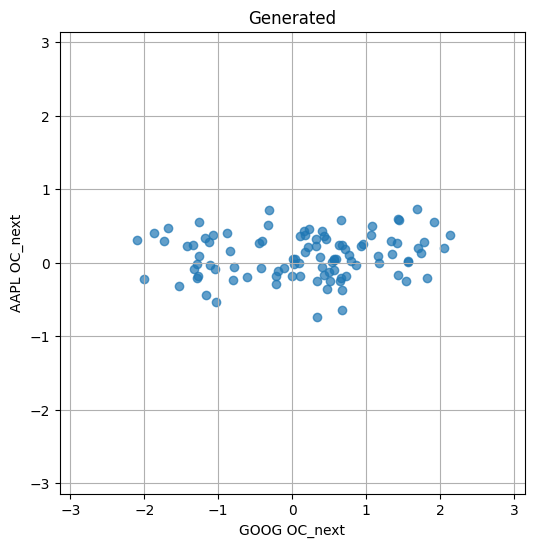

In [ ]:
compare_tickers_scatter(df_gen, "GOOG", "AAPL", title= "Generated", feature="OC_next")

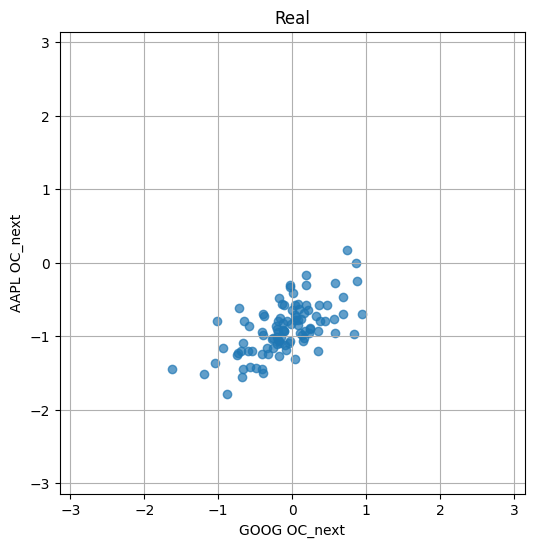

In [ ]:
compare_tickers_scatter(df_real, "GOOG", "AAPL",title= "Real", feature="OC_next")